In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csgraph
import umap
from sklearn import linear_model
from collections import Counter
import sklearn
import scipy.stats as sps
from scipy.spatial.distance import cdist
from importlib import reload
import mygene

import gget

# locals
import utils as ut
reload(ut)

2023-03-09 09:14:02.372383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 09:14:13.229005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-03-09 09:14:13.229029: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-09 09:14:14.786944: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-09 09:14:26.0819

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
xy['metaTypes'] = xy['cellTypes']
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors', 'metaTypes']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
HFD8...
HFD14...
done


In [3]:
def getGroup(rna, labels, key, ctype):
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'] == ctype]['cellId'].to_list()
    return rf[rf.index.isin(cellIds)]


atm = getGroup(rna, labels, 'ND', 'Mac1')
lam = getGroup(rna, labels, 'HFD14', 'Mac5')
print(atm.shape, lam.shape)

(136, 31053) (1870, 31053)


In [4]:
cType = "Macrophages"
t = 0.5 # percent of the population the must express the gene
xId = '00190'
yId = '04145'

xPathId = f"mmu{xId}"
xGenes = ut.parseKEGG(xPathId)
xPathname = ut.getPathname(xPathId)
xGenes = [x.upper() for x in xGenes]
print(f"{xPathname=}  {len(xGenes)=}")

yPathId = f"mmu{yId}"
yGenes = ut.parseKEGG(yPathId)
yPathname = ut.getPathname(yPathId)
yGenes = [x.upper() for x in yGenes]
print(f"{yPathname=} {len(yGenes)=}")

res = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    
    cellIds = lf[lf['metaTypes'] == cType]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # require that pathway genes are expresses
    xCols = [x for x in xGenes if x in rf.columns]
    yCols = [x for x in yGenes if x in rf.columns]
    
    # filter out the genes not expressed in t percent of the 
    # population
    n = len(rf)
    thresh = int(n * t)

    rfBool = rf.astype(bool).astype(int)
    xSums = rfBool[xCols].sum(axis=0)
    ySums = rfBool[yCols].sum(axis=0)
    
    xCols = xSums[xSums > thresh].index.to_list()
    yCols = ySums[ySums > thresh].index.to_list()
    
    print(f"{key} {len(xCols)} genes in {xPathname} in > {thresh} cells ({t*100}%)")
    print(f"{key} {len(yCols)} genes in {yPathname} in > {thresh} cells ({t*100}%)")
    print()
    
    assert(len(xCols) > 0)
    assert(len(yCols) > 0)
    
    xAgg = rf[xCols].mean(axis=1)
    yAgg = rf[yCols].mean(axis=1)
    
    # xAgg = rf[xCols].median(axis=1)
    # yAgg = rf[yCols].median(axis=1)
    
    af = pd.concat([xAgg, yAgg], axis=1)
    af.columns = ['x', 'y']
    af = af.reset_index(drop=False)
    af['key'] = key
    
    res.append(af)

res = pd.concat(res, ignore_index=True)
res.head()

xPathname='Oxidative phosphorylation'  len(xGenes)=135
yPathname='Phagosome' len(yGenes)=181
ND 64 genes in Oxidative phosphorylation in > 180 cells (50.0%)
ND 44 genes in Phagosome in > 180 cells (50.0%)

HFD8 67 genes in Oxidative phosphorylation in > 1096 cells (50.0%)
HFD8 51 genes in Phagosome in > 1096 cells (50.0%)

HFD14 86 genes in Oxidative phosphorylation in > 1944 cells (50.0%)
HFD14 60 genes in Phagosome in > 1944 cells (50.0%)



,cellId,x,y,key
0,AAAGAACGTCTACAGT.1,274.423710,906.429831,ND
1,AAAGAACTCCTCGCAT.1,137.938645,1384.402400,ND
2,AAAGGGCGTTAGGGTG.1,293.985889,1560.288743,ND
3,AACAAAGCACCGGCTA.1,223.615991,1550.339283,ND
4,AACAAAGGTTCACGAT.1,419.706516,1017.470343,ND


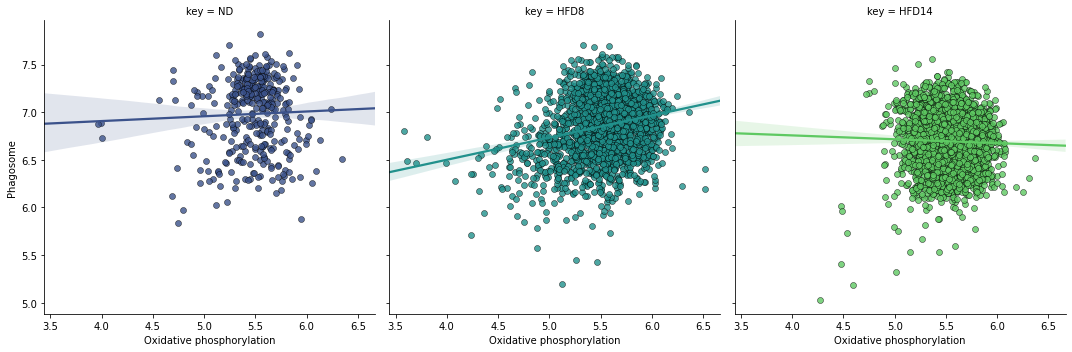

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.facecolor'] = "w"

pdf = res.copy()
pdf['xlog'] = np.log(pdf['x'])
pdf['ylog'] = np.log(pdf['y'])

g = sns.lmplot(data=pdf,
               x="xlog", 
               y="ylog", 
               col="key", 
               hue="key", 
               palette='viridis',
               scatter_kws={'linewidths': 0.5,
                            'edgecolor': 'k'},
               y_jitter=.02, 
               truncate=False)


g.set_axis_labels(xPathname.replace("pathway", ""), 
                  yPathname.replace("pathway", ""))

# g.set_titles("ND", "8w", "14w")
plt.tight_layout()

In [6]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [7]:
pathways = {    
    # "00561" :  "Glycerolipid metabolism",
    # "00600" :  "Sphingolipid metabolism",
    "00190" :  "Oxidative phosphorylation",
    "04975" :  "Fat digestion and absorption",
    "04979" :  "Cholesterol metabolism",
    # "03320" :  "PPAR signaling pathway",
    # "04512" :  "ECM-receptor interaction",
    # "04514" :  "Cell adhesion molecules",
    "04142" :  "Lysosome",
    "04140" :  "Autophagy",
    "04210" :  "Apoptosis",
    "04216" :  "Ferroptosis",
    "04217" :  "Necroptosis",
}

pwayGenes = {}

for pid, pname in pathways.items():
    pidFull = f"mmu{pid}"
    g = ut.parseKEGG(pidFull)
    g = [x.upper() for x in g]
    print(f"{pname=} {len(g)}")
    pwayGenes[pname] = g

print('done')

pname='Oxidative phosphorylation' 135
pname='Fat digestion and absorption' 43
pname='Cholesterol metabolism' 50
pname='Lysosome' 135
pname='Autophagy' 142
pname='Apoptosis' 136
pname='Ferroptosis' 40
pname='Necroptosis' 176
done


In [ ]:
break

In [8]:
res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    print(f"{key}...")
    
    for pid, pname in pathways.items():
        genes = pwayGenes[pname]
        exG = [x for x in genes if x in rf.columns]
        
        meanExp = rf[exG].mean(axis=1).reset_index(drop=False)
        meanExp.columns = ['cellId', 'mean']
        meanExp['pway'] = pname
        meanExp['key'] = key
        
        meanExp = pd.merge(meanExp, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                       how='left', 
                       right_on='cellId',
                       left_on='cellId')
        
        res.append(meanExp)
    
res = pd.concat(res)
print(f"{res.shape=}")
res.head()

ND...
HFD8...
HFD14...
res.shape=(51448, 8)


,cellId,mean,pway,key,cellType,x,y,metaTypes
0,AAAGAACGTCTACAGT.1,162.963100,Oxidative phosphorylation,ND,Mac1,3.089298,-1.726030,Macrophages
1,AAAGAACTCCTCGCAT.1,87.167950,Oxidative phosphorylation,ND,Mac1,3.614130,-1.571004,Macrophages
2,AAAGGGCGTTAGGGTG.1,172.227027,Oxidative phosphorylation,ND,Mac3,3.086352,6.166065,Macrophages
3,AACAAAGCACCGGCTA.1,134.666944,Oxidative phosphorylation,ND,Mac3,4.344001,5.801922,Macrophages
4,AACAAAGGTTCACGAT.1,248.018292,Oxidative phosphorylation,ND,Mac1,0.130051,-1.583494,Macrophages


pdf.shape=(51448, 8)
pdf.shape=(51204, 8)


Text(0.5, 86.9999999999997, 'Mean Expression')

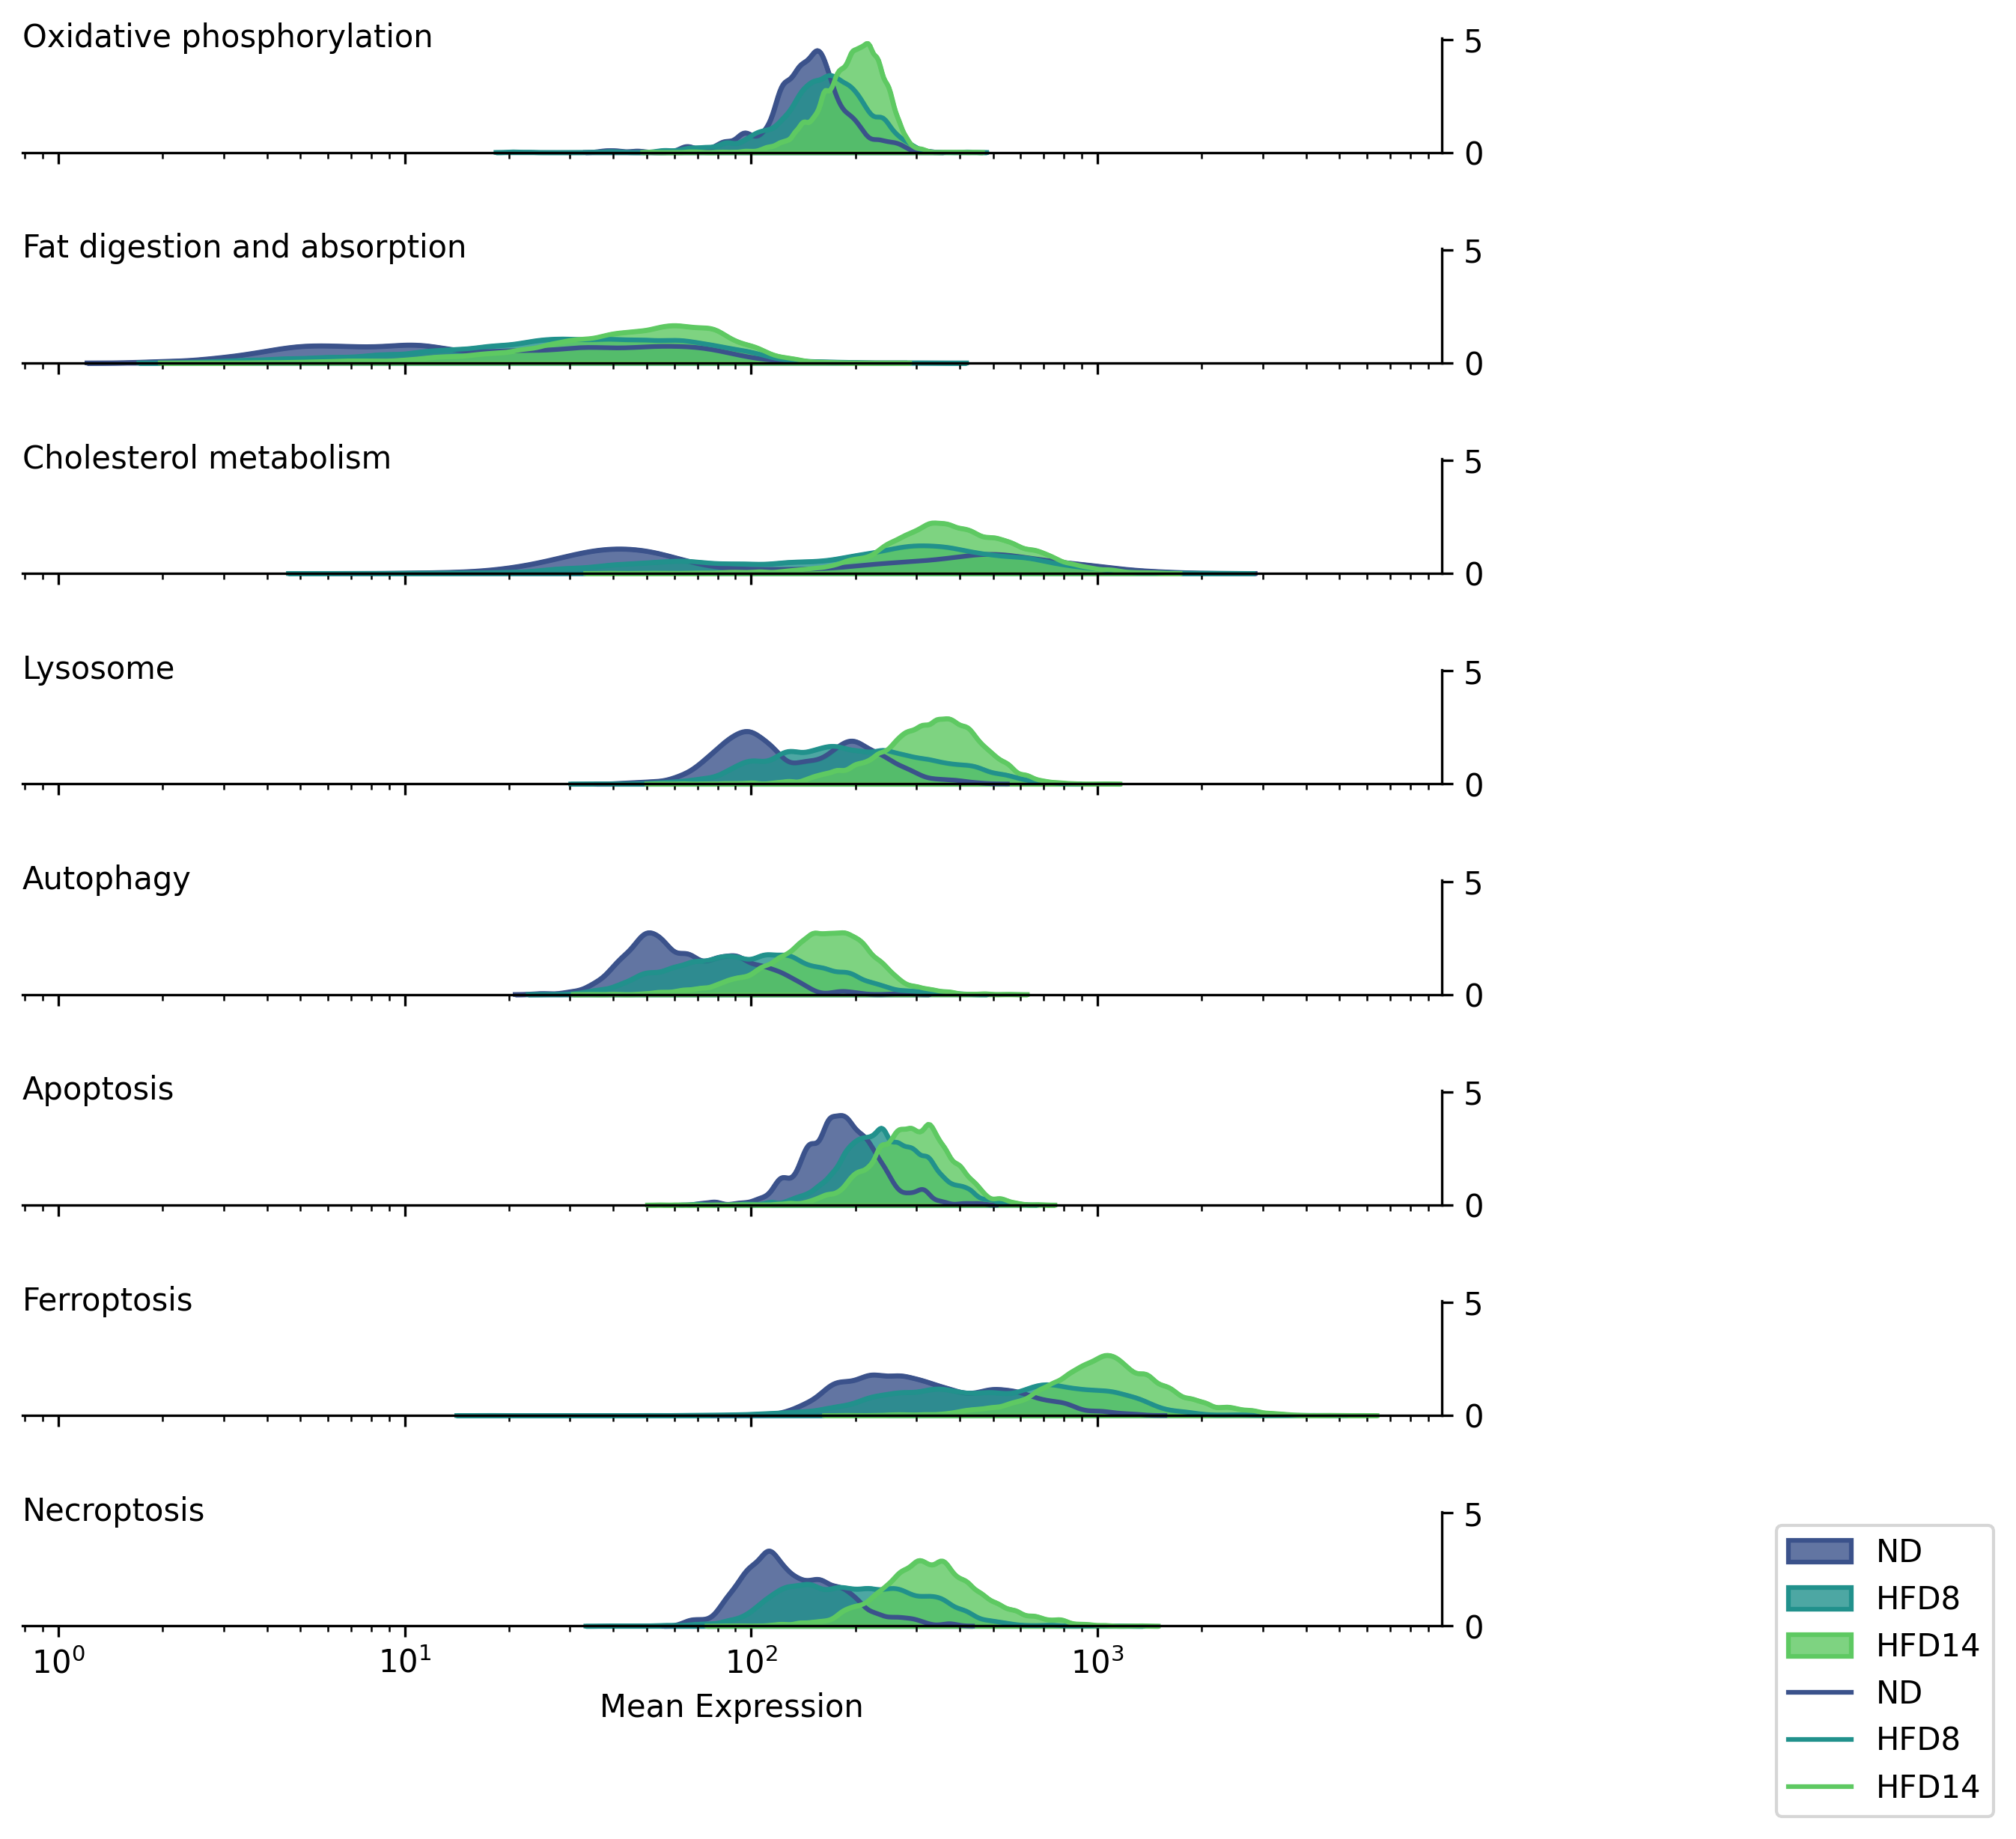

In [9]:
pdf = res.copy()
pdf = pdf.fillna(0)
print(f"{pdf.shape=}")
pdf = pdf[pdf['mean'] > 0]
print(f"{pdf.shape=}")

g = sns.FacetGrid(pdf, 
                  row="pway", 
                  hue="key", 
                  height=1, 
                  aspect=7,
                  palette='viridis')

# Draw the densities in a few steps
g.map(sns.kdeplot, "mean",
      bw_adjust=.5, 
      clip_on=False,
      fill=True, 
      log_scale=True,
      alpha=0.8, 
      linewidth=1.5)

g.map(sns.kdeplot, "mean", 
      clip_on=False, 
      # color="k", 
      log_scale=True,
      lw=1.5, 
      bw_adjust=.5)

g.set_titles("")

g.set(ylabel="")

g.despine(bottom=False, left=True, right=False)

for ax, label in zip(g.axes.flat, pdf['pway'].unique()):
    ax.text(0, 1, label, 
            # fontweight="bold", 
            # color=color,
            ha="left", 
            va="center", 
            transform=ax.transAxes)


plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
plt.xlabel('Mean Expression')

In [ ]:
# # try with fold changes

# lfdf = []

# macTypes = [
#     'Mac1',
#     'Mac2',
#     'Mac3',
#     'Mac4',
#     'Mac5',
# ]

# for key in keys:
#     rf = rna[key]
#     lf = labels[key]
#     lf = lf.drop_duplicates(subset='cellId')
    
    
    
# #     cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
# #     rf = rf[rf.index.isin(cellIds)]
# #     print(f"{key}...")
    
#     for mtype in macTypes:
        
#         cellIds = lf[lf['cellType'] == mtype]['cellId'].to_list()
        
#         mask = rf.index.isin(cellIds)
#         inGroup = rf[mask]
#         outGroup = rf[~mask]
        
#         for g in rf.columns:
            
#             score, pval = scipy.stats.ranksums(inGroup[g], 
#                                            outGroup[g],
#                                            alternative='two-sided')

#             lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)
            
#             row = {
#                 'key' : key,
#                 'mtype' : mtype,
#                 'gene' : g,
#                 'score' : score,
#                 'pval' : pval,
#                 'log2foldchange' : lfc, 
#                 'inGroup' : inGroup[g].mean(),
#                 'outGroup' : outGroup[g].mean(),
#             }
#             lfdf.append(row)
            

        
        
        
        
        
#     break
    
    
# lfdf = pd.DataFrame(lfdf)
# lfdf.head(10)



In [ ]:
res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

pwayGenes = {
    'Proliferation' : ['MKI67']
}

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    print(f"\n{key}...")
    
    for pname, genes in pwayGenes.items():
        xGenes = [x for x in genes if x in rf.columns]
        
        pdf = rf[xGenes].reset_index(drop=False)
        print(pdf.head())
        
        # print(pname)
        break
        
    break
        
#         print(f"{pname} {len(xGenes)}")
        
#         meanExp = rf[xGenes].astype(bool).sum(axis=1).reset_index(drop=False)
#         meanExp.columns = ['cellId', 'mean']
#         meanExp['meanNorm'] = meanExp['mean'] / len(xGenes)
#         meanExp['pway'] = pname
#         meanExp['key'] = key
        
#         meanExp = pd.merge(meanExp, lf[['cellId', 'cellType','metaTypes']], 
#                        how='left', 
#                        right_on='cellId',
#                        left_on='cellId')
        
#         res.append(meanExp)

    
# res = pd.concat(res)
# print(f"{res.shape=}")
# res.head()

In [ ]:
t = rf[xGenes].astype(float)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"

sns.heatmap(data=t.T)

In [ ]:
# t = 0.1 # require t percent of the cells to express this gene

# res = []

# macTypes = [
#     'Mac1',
#     'Mac2',
#     'Mac3',
#     'Mac4',
#     'Mac5',
# ]

# for key in keys:
#     rf = rna[key]
#     lf = labels[key]
#     lf = lf.drop_duplicates(subset='cellId')
    
#     cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
#     rf = rf[rf.index.isin(cellIds)]
#     print(f"\n{key}...")
    
#     n = len(rf)
#     thresh = int(n * t)
#     rfBool = rf.astype(bool).astype(int)
    
#     for pid, pname in pathways.items():
#         genes = pwayGenes[pname]
#         xGenes = [x for x in genes if x in rf.columns]
        
#         geneCounts = rfBool[xGenes].sum(axis=0)
#         cols = geneCounts[geneCounts > thresh].index.to_list()
#         print(f"{pname=} {len(cols)=}")

#         # meanExp = rf[cols].mean(axis=1).reset_index(drop=False)
#         meanExp = rf[cols].max(axis=1).reset_index(drop=False)
#         meanExp.columns = ['cellId', 'mean']
#         meanExp['pway'] = pname
#         meanExp['key'] = key
        
#         meanExp = pd.merge(meanExp, lf[['cellId', 'cellType','metaTypes']], 
#                        how='left', 
#                        right_on='cellId',
#                        left_on='cellId')
        
#         res.append(meanExp)

    
# res = pd.concat(res)
# print(f"{res.shape=}")
# res.head()

In [ ]:

res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    print(f"\n{key}...")
    
    n = len(rf)
    thresh = int(n * t)
    rfBool = rf.astype(bool).astype(int)
    
    for pid, pname in pathways.items():
        genes = pwayGenes[pname]
        xGenes = [x for x in genes if x in rf.columns]
        
        print(f"{pname} {len(xGenes)}")
        
        meanExp = rf[xGenes].astype(bool).sum(axis=1).reset_index(drop=False)
        meanExp.columns = ['cellId', 'mean']
        meanExp['meanNorm'] = meanExp['mean'] / len(xGenes)
        meanExp['pway'] = pname
        meanExp['key'] = key
        
        meanExp = pd.merge(meanExp, lf[['cellId', 'cellType','metaTypes']], 
                       how='left', 
                       right_on='cellId',
                       left_on='cellId')
        
        res.append(meanExp)

    
res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
# pdf = res.copy()
# pdf = pdf.fillna(0)
# print(f"{pdf.shape=}")
# pdf = pdf[pdf['mean'] > 0]
# pdf['index'] = pdf['key'] + "_" + pdf['cellId']
# pdf = pdf.set_index('index')
# print(f"{pdf.shape=}")

# k = pdf[['pway', 'mean']].value_counts().reset_index(drop=False)
# k.columns = ['pway', 'geneCount', 'cellCount']
# k.head()

# sns.barplot(data=k, 
#             y='cellCount',
#              x="geneCount",)

In [ ]:
res.head()

In [ ]:
pdf = res.copy()
pdf = pdf.fillna(0)
print(f"{pdf.shape=}")
pdf = pdf[pdf['mean'] > 0]
pdf['index'] = pdf['key'] + "_" + pdf['cellId']
pdf = pdf.set_index('index')
pdf = pdf.reset_index(drop=False)
print(f"{pdf.shape=}")

# # mask = pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5'])
# # pdf = pdf[mask]

g = sns.FacetGrid(pdf, 
                  row="pway", 
                  hue="cellType", 
                  height=1, 
                  aspect=6,
                  palette='Spectral')

# Draw the densities in a few steps
g.map(sns.stripplot, 
      "meanNorm", 
      # orient='h',
      # stat='probability',
      # bw_adjust=.5, 
      # clip_on=False,
      # fill=True, 
      # log_scale=True,
      alpha=0.8)


g.set_titles("")

g.set(ylabel="", 
      # ylim=[0, 0.2],
      # yticks=[],
     )
# # g.despine(bottom=False, left=True)

# for ax, label in zip(g.axes.flat, pdf['pway'].unique()):
#     ax.text(0.1, 1, label, 
#             # fontweight="bold", 
#             # color=color,
#             ha="left", 
#             va="center", 
#             transform=ax.transAxes)


# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
# # plt.xlabel('Mean Expression')

In [ ]:
# pdf = res.copy()
# print(f"{pdf.shape=}")
# pdf = pdf[pdf['mean'] > 0]
# print(f"{pdf.shape=}")


# # pdf = pd.pivot_table(pdf, 
# #                      index=['pway', 'cellId'],
# #                      columns='key').reset_index(drop=False)

# # pdf.columns = pdf.columns.droplevel()
# # pdf.columns = ['pway', 'cellId', 'HFD14', 'HFD8', "ND"]
# # pdf = pdf[['pway', 'cellId', "ND", "HFD8", "HFD14"]]
# # pdf = pdf.fillna(0)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"


# sns.stripplot(data=pdf,
#               x='mean',
#               y='pway',
#               hue='key',
#               dodge=True,
#               jitter=True,
#               alpha=0.1,
#               zorder=3,
#               palette='viridis',
#               size=2,)
              
# plt.xscale('log')
# plt.grid(True, zorder=1)
# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.015))



In [ ]:
# sns.swarmplot(data=pdf, 
#               x="mean", 
#               y="pway", 
#               hue="key",
#               dodge=True, 
#               s=2,
#               alpha=.1, 
#               zorder=2,
#               palette='viridis',
# )
# plt.grid(True, zorder=0)

# plt.xscale('log')

# plt.legend(loc='upper right')
# plt.ylabel("")
# plt.xlabel('Mean Expression (CPM)')

In [ ]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 8, 8
# plt.rcParams['figure.facecolor'] = "w"

# pdf = res.copy()
# pdf['xlog'] = np.log(pdf['x'])
# pdf['ylog'] = np.log(pdf['y'])

# g = sns.catplot(data=pdf,
#                 x="xlog", 
#                 y="ylog", 
#                 hue="key", 
#                 # col="diet",
#                 capsize=.2, 
#                 palette="viridis", 
#                 errorbar="se",
#                 kind="point", 
#                 height=6, 
#                 aspect=.75,
# )

In [ ]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 8, 8
# plt.rcParams['figure.facecolor'] = "w"

# pdf = res.copy()
# pdf['xlog'] = np.log(pdf['x'])
# pdf['ylog'] = np.log(pdf['y'])

# g = sns.swarmplot(data=pdf, 
#                   x="xlog", 
#                   y="ylog", 
#                   hue="key")


In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['figure.facecolor'] = "w"

pdf = res.copy()
pdf['xlog'] = np.log(pdf['x'])
pdf['ylog'] = np.log(pdf['y'])

h = sns.jointplot(data=pdf,
              dropna=True,
              x='xlog', 
              y='ylog', 
              hue='key',
              kind='kde',
              alpha=0.5,
              ec='k',
              size=10,
              linewidths=0.5,
              palette='viridis')

h.set_axis_labels(xPathname, 
                  yPathname, 
                  fontsize=16)

